In [40]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

I0702 06:01:03.038983 4657720768 <ipython-input-40-bf2b01b18efd>:11] --=logging started=--


In [41]:
import sys
TRAIN = True
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [42]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [43]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [44]:

if not IN_COLAB:
  import analyser.hyperparams  
  _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
  work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)
  
  if not os.path.isdir(work_dir):
    os.mkdir(work_dir)

  analyser.hyperparams.work_dir = work_dir
else:
  import analyser.hyperparams
  from google.colab import drive
  drive.mount('/content/drive')
  os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
  analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)
assert os.path.isdir(analyser.hyperparams.work_dir)

work_dir= /Users/artem/work/nemo/goil/work


# Imports

In [45]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 
import os
import random
import math
import json
import warnings

from os import path

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, seq_labels_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


1.15.2


# Prepare trainset


In [97]:
umtm = UberModelTrainsetManager ( analyser.hyperparams.work_dir)

if not IN_COLAB:
#   umtm.export_docs_to_json()
  umtm.import_recent_contracts()
  umtm.calculate_samples_weights()
  umtm.validate_trainset()

I0702 13:11:38.905412 4657720768 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 0
I0702 13:11:38.944957 4657720768 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 0
I0702 13:11:38.948366 4657720768 retrain_contract_uber_model.py:177] latest export_date: [1900-01-01 00:00:00]
I0702 13:11:38.951545 4657720768 retrain_contract_uber_model.py:179] obtaining DB connection...
I0702 13:11:39.021281 4657720768 retrain_contract_uber_model.py:182] obtaining DB connection: DONE
I0702 13:11:39.076651 4657720768 retrain_contract_uber_model.py:203] running DB query {'$and': [{'parse.documentType': 'CONTRACT'}, {'state': 15}, {'$or': [{'analysis.attributes': {'$ne': None}}, {'user.attributes': {'$ne': None}}]}, {'$or': [{'analysis.analyze_timestamp': {'$gt': datetime.datetime(1900, 1, 1, 0, 0)}}, {'user.updateDate': {'$gt': datetime.datetime(1900, 1, 1, 0, 0)}}]}]}
I0702 13:11:39.111530 4657720768 retrain_contract_uber_model.py:213] running DB query: DONE


exporting JSON  0 5df905d8fd0198a0617a28eb
exporting JSON  1 5df905d8fd0198a0617a28ed
exporting JSON  2 5df905d8fd0198a0617a28ec
exporting JSON  3 5df905d9fd0198a0617a28ee
exporting JSON  4 5df905d9fd0198a0617a28ef
exporting JSON  5 5deba9034ddc27bcf92dd383
exporting JSON  6 5ded4e284ddc27bcf92dd6ce
exporting JSON  7 5ded4e294ddc27bcf92dd6d4
exporting JSON  8 5ded4e294ddc27bcf92dd6d5
exporting JSON  9 5df620b9200a3f4d0fad777c
exporting JSON  10 5df620b9200a3f4d0fad777d
exporting JSON  11 5dfa6a928d25a1ac83160be9
exporting JSON  12 5dfa6a938d25a1ac83160bee
exporting JSON  13 5dfa6a938d25a1ac83160bef
exporting JSON  14 5dfa6a938d25a1ac83160bf1
exporting JSON  15 5e58df7523869ee435388232
exporting JSON  16 5e58df7823869ee435388239
exporting JSON  17 5e58df7823869ee43538823a
exporting JSON  18 5e58df7823869ee43538823b
exporting JSON  19 5e58df7823869ee43538823d
exporting JSON  20 5e58df7823869ee43538823e
exporting JSON  21 5e58df7823869ee435388242
exporting JSON  22 5ee188882281f29204c5229

exporting JSON  267 5edbc59eda3678279fbcacae
exporting JSON  268 5edbc59fda3678279fbcaccb
exporting JSON  269 5edbc59fda3678279fbcaccd
exporting JSON  270 5edbc5a0da3678279fbcacdd
exporting JSON  271 5edbc5a1da3678279fbcad00
exporting JSON  272 5edbc5a9da3678279fbcad29
exporting JSON  273 5edbc5aada3678279fbcad32
exporting JSON  274 5edbc5acda3678279fbcad40
exporting JSON  275 5edbc5adda3678279fbcad52
exporting JSON  276 5edbc5adda3678279fbcad5d
exporting JSON  277 5edbc5aeda3678279fbcad65
exporting JSON  278 5edbc5afda3678279fbcad6a
exporting JSON  279 5edbc5afda3678279fbcad6e
exporting JSON  280 5edbc5b0da3678279fbcad7c
exporting JSON  281 5edbc5b1da3678279fbcad8e
exporting JSON  282 5edbc605da3678279fbcad99
exporting JSON  283 5edbc607da3678279fbcada2
exporting JSON  284 5edbc60bda3678279fbcadad
exporting JSON  285 5edbc60fda3678279fbcadae
exporting JSON  286 5edbc614da3678279fbcadbd
exporting JSON  287 5edbc615da3678279fbcadbf
exporting JSON  288 5edbc615da3678279fbcadc9
exporting 

exporting JSON  494 5eea2796c28b75807f3dac4e
exporting JSON  495 5eea2796c28b75807f3dac59
exporting JSON  496 5eea2797c28b75807f3dac5d
exporting JSON  497 5eea2797c28b75807f3dac5f
exporting JSON  498 5eea2798c28b75807f3dac63
exporting JSON  499 5eea2798c28b75807f3dac6b
exporting JSON  500 5eea2798c28b75807f3dac6c
exporting JSON  501 5eea2798c28b75807f3dac6d
exporting JSON  502 5eea2799c28b75807f3dac70
exporting JSON  503 5eea2799c28b75807f3dac73
exporting JSON  504 5eea2799c28b75807f3dac76
exporting JSON  505 5eea2799c28b75807f3dac7b
exporting JSON  506 5eea2799c28b75807f3dac7c
exporting JSON  507 5eea279ac28b75807f3dac7e
exporting JSON  508 5eea279ac28b75807f3dac80
exporting JSON  509 5eea279ac28b75807f3dac88
exporting JSON  510 5eea279ac28b75807f3dac89
exporting JSON  511 5eea279ac28b75807f3dac8a
exporting JSON  512 5eea279ac28b75807f3dac93
exporting JSON  513 5eea279ac28b75807f3dac95
exporting JSON  514 5eea279bc28b75807f3dac9b
exporting JSON  515 5eea279bc28b75807f3dac9d
exporting 

I0702 13:12:29.938834 4657720768 retrain_contract_uber_model.py:566] EXPORTED 686 docs
I0702 13:12:32.642661 4657720768 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 0
I0702 13:12:32.645552 4657720768 retrain_contract_uber_model.py:177] latest export_date: [1900-01-01 00:00:00]
I0702 13:12:32.646405 4657720768 retrain_contract_uber_model.py:179] obtaining DB connection...
I0702 13:12:32.648864 4657720768 retrain_contract_uber_model.py:182] obtaining DB connection: DONE
I0702 13:12:32.651258 4657720768 retrain_contract_uber_model.py:203] running DB query {'$and': [{'parse.documentType': 'CONTRACT'}, {'state': 15}, {'$or': [{'analysis.attributes': {'$ne': None}}, {'user.attributes': {'$ne': None}}]}, {'$or': [{'analysis.analyze_timestamp': {'$gt': datetime.datetime(1900, 1, 1, 0, 0)}}, {'user.updateDate': {'$gt': datetime.datetime(1900, 1, 1, 0, 0)}}]}]}
I0702 13:12:32.657626 4657720768 retrain_contract_uber_model.py:213] running DB query: DONE


creating ElmoEmbedderImpl instance


I0702 13:12:33.602158 4657720768 retrain_contract_uber_model.py:283] docs in meta: 1
I0702 13:12:33.624466 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 1
I0702 13:12:33.704634 4657720768 retrain_contract_uber_model.py:283] docs in meta: 2
I0702 13:12:33.707919 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 2
I0702 13:12:33.763432 4657720768 retrain_contract_uber_model.py:283] docs in meta: 3
I0702 13:12:33.768090 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 3
I0702 13:12:33.940222 4657720768 retrain_contract_uber_model.py:283] docs in meta: 4
I0702 13:12:33.943717 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 4
I0702 13:12:34.035039 4657720768 retrain_contract_uber_model.py:283] docs in meta: 5
I0702 13:12:34.038738 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 5
I0702 13:12:34.153223 4657720768 retrain

I0702 13:12:49.142143 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 43
I0702 13:12:49.333444 4657720768 retrain_contract_uber_model.py:283] docs in meta: 44
I0702 13:12:49.339548 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 44
I0702 13:12:49.406722 4657720768 retrain_contract_uber_model.py:283] docs in meta: 45
I0702 13:12:49.412276 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 45
I0702 13:12:49.664777 4657720768 retrain_contract_uber_model.py:283] docs in meta: 46
I0702 13:12:49.670710 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 46
I0702 13:12:49.827425 4657720768 retrain_contract_uber_model.py:283] docs in meta: 47
I0702 13:12:49.833019 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 47
I0702 13:12:50.053301 4657720768 retrain_contract_uber_model.py:283] docs in meta: 48
I0702 13:12:50.061651 46577207

I0702 13:13:01.253967 4657720768 retrain_contract_uber_model.py:283] docs in meta: 68
I0702 13:13:01.259575 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 68
I0702 13:13:01.327600 4657720768 retrain_contract_uber_model.py:283] docs in meta: 69
I0702 13:13:01.333278 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 68
I0702 13:13:01.514740 4657720768 retrain_contract_uber_model.py:283] docs in meta: 69
I0702 13:13:01.519214 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 68
I0702 13:13:01.575384 4657720768 retrain_contract_uber_model.py:283] docs in meta: 69
I0702 13:13:01.580364 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 69
I0702 13:13:01.647653 4657720768 retrain_contract_uber_model.py:283] docs in meta: 70
I0702 13:13:01.653794 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 70
I0702 13:13:01.725257 46577207

I0702 13:13:12.558437 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 100
I0702 13:13:13.120044 4657720768 retrain_contract_uber_model.py:283] docs in meta: 101
I0702 13:13:13.143024 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 100
I0702 13:13:13.690082 4657720768 retrain_contract_uber_model.py:283] docs in meta: 101
I0702 13:13:13.697736 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 101
I0702 13:13:14.054603 4657720768 retrain_contract_uber_model.py:283] docs in meta: 102
I0702 13:13:14.076398 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 102
I0702 13:13:14.195495 4657720768 retrain_contract_uber_model.py:283] docs in meta: 103
I0702 13:13:14.206864 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 103
I0702 13:13:14.555398 4657720768 retrain_contract_uber_model.py:283] docs in meta: 104
I0702 13:13:14.57601

I0702 13:13:27.649286 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 140
I0702 13:13:27.750745 4657720768 retrain_contract_uber_model.py:283] docs in meta: 141
I0702 13:13:27.760856 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 140
I0702 13:13:27.815140 4657720768 retrain_contract_uber_model.py:283] docs in meta: 141
I0702 13:13:27.820543 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 141
I0702 13:13:27.864562 4657720768 retrain_contract_uber_model.py:283] docs in meta: 142
I0702 13:13:27.869776 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 142
I0702 13:13:28.035386 4657720768 retrain_contract_uber_model.py:283] docs in meta: 143
I0702 13:13:28.041117 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 143
I0702 13:13:28.182677 4657720768 retrain_contract_uber_model.py:283] docs in meta: 144
I0702 13:13:28.18750

I0702 13:13:34.737418 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 168
I0702 13:13:34.890225 4657720768 retrain_contract_uber_model.py:283] docs in meta: 169
I0702 13:13:34.897393 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 169
I0702 13:13:35.042166 4657720768 retrain_contract_uber_model.py:283] docs in meta: 170
I0702 13:13:35.047632 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 170
I0702 13:13:35.159547 4657720768 retrain_contract_uber_model.py:283] docs in meta: 171
I0702 13:13:35.166343 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 171
I0702 13:13:35.407958 4657720768 retrain_contract_uber_model.py:283] docs in meta: 172
I0702 13:13:35.425073 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 172
I0702 13:13:35.541352 4657720768 retrain_contract_uber_model.py:283] docs in meta: 173
I0702 13:13:35.54536

I0702 13:13:42.323217 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 210
I0702 13:13:42.525289 4657720768 retrain_contract_uber_model.py:283] docs in meta: 211
I0702 13:13:42.531322 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 211
I0702 13:13:42.695556 4657720768 retrain_contract_uber_model.py:283] docs in meta: 212
I0702 13:13:42.702646 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 212
I0702 13:13:42.873287 4657720768 retrain_contract_uber_model.py:283] docs in meta: 213
I0702 13:13:42.879002 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 213
I0702 13:13:43.171383 4657720768 retrain_contract_uber_model.py:283] docs in meta: 214
I0702 13:13:43.177030 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 214
I0702 13:13:43.272871 4657720768 retrain_contract_uber_model.py:283] docs in meta: 215
I0702 13:13:43.28099

I0702 13:13:49.125905 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 252
I0702 13:13:49.620394 4657720768 retrain_contract_uber_model.py:283] docs in meta: 253
I0702 13:13:49.626149 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 253
I0702 13:13:49.682695 4657720768 retrain_contract_uber_model.py:283] docs in meta: 254
I0702 13:13:49.688724 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 254
I0702 13:13:49.874352 4657720768 retrain_contract_uber_model.py:283] docs in meta: 255
I0702 13:13:49.885015 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 255
I0702 13:13:50.132093 4657720768 retrain_contract_uber_model.py:283] docs in meta: 256
I0702 13:13:50.137537 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 256
I0702 13:13:50.329941 4657720768 retrain_contract_uber_model.py:283] docs in meta: 257
I0702 13:13:50.34499

I0702 13:13:58.864562 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 294
I0702 13:13:59.397483 4657720768 retrain_contract_uber_model.py:283] docs in meta: 295
I0702 13:13:59.432814 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 294
I0702 13:13:59.728410 4657720768 retrain_contract_uber_model.py:283] docs in meta: 295
I0702 13:13:59.741600 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 295
I0702 13:13:59.968793 4657720768 retrain_contract_uber_model.py:283] docs in meta: 296
I0702 13:13:59.980260 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 296
I0702 13:14:00.138231 4657720768 retrain_contract_uber_model.py:283] docs in meta: 297
I0702 13:14:00.145893 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 297
I0702 13:14:00.215536 4657720768 retrain_contract_uber_model.py:283] docs in meta: 298
I0702 13:14:00.22187

I0702 13:14:09.519482 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 334
I0702 13:14:09.644147 4657720768 retrain_contract_uber_model.py:283] docs in meta: 335
I0702 13:14:09.649757 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 335
I0702 13:14:09.871035 4657720768 retrain_contract_uber_model.py:283] docs in meta: 336
I0702 13:14:09.876353 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 336
I0702 13:14:09.987647 4657720768 retrain_contract_uber_model.py:283] docs in meta: 337
I0702 13:14:09.992693 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 337
I0702 13:14:10.386433 4657720768 retrain_contract_uber_model.py:283] docs in meta: 338
I0702 13:14:10.394451 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 338
I0702 13:14:10.738512 4657720768 retrain_contract_uber_model.py:283] docs in meta: 339
I0702 13:14:10.74581

I0702 13:14:32.467885 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 376
I0702 13:14:32.589509 4657720768 retrain_contract_uber_model.py:283] docs in meta: 377
I0702 13:14:32.603460 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 377
I0702 13:14:32.853490 4657720768 retrain_contract_uber_model.py:283] docs in meta: 378
I0702 13:14:32.859439 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 378
I0702 13:14:33.038530 4657720768 retrain_contract_uber_model.py:283] docs in meta: 379
I0702 13:14:33.046554 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 379
I0702 13:14:33.218611 4657720768 retrain_contract_uber_model.py:283] docs in meta: 380
I0702 13:14:33.225180 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 380
I0702 13:14:33.327838 4657720768 retrain_contract_uber_model.py:283] docs in meta: 381
I0702 13:14:33.33781

I0702 13:14:42.384910 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 418
I0702 13:14:42.645309 4657720768 retrain_contract_uber_model.py:283] docs in meta: 419
I0702 13:14:42.654932 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 419
I0702 13:14:42.963844 4657720768 retrain_contract_uber_model.py:283] docs in meta: 420
I0702 13:14:43.072757 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 420
I0702 13:14:43.338845 4657720768 retrain_contract_uber_model.py:283] docs in meta: 421
I0702 13:14:43.360233 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 421
I0702 13:14:43.735225 4657720768 retrain_contract_uber_model.py:283] docs in meta: 422
I0702 13:14:43.745541 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 422
I0702 13:14:44.052303 4657720768 retrain_contract_uber_model.py:283] docs in meta: 423
I0702 13:14:44.07195

I0702 13:15:06.380884 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 458
I0702 13:15:06.494668 4657720768 retrain_contract_uber_model.py:283] docs in meta: 459
I0702 13:15:06.502540 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 459
I0702 13:15:06.691810 4657720768 retrain_contract_uber_model.py:283] docs in meta: 460
I0702 13:15:06.717797 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 459
I0702 13:15:06.807168 4657720768 retrain_contract_uber_model.py:283] docs in meta: 460
I0702 13:15:06.813611 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 460
I0702 13:15:07.219100 4657720768 retrain_contract_uber_model.py:283] docs in meta: 461
I0702 13:15:07.234872 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 461
I0702 13:15:07.975219 4657720768 retrain_contract_uber_model.py:283] docs in meta: 462
I0702 13:15:07.99069

I0702 13:15:16.569961 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 492
I0702 13:15:16.646018 4657720768 retrain_contract_uber_model.py:283] docs in meta: 493
I0702 13:15:16.652748 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 493
I0702 13:15:16.722472 4657720768 retrain_contract_uber_model.py:283] docs in meta: 494
I0702 13:15:16.728513 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 494
I0702 13:15:16.920288 4657720768 retrain_contract_uber_model.py:283] docs in meta: 495
I0702 13:15:16.929208 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 495
I0702 13:15:17.077040 4657720768 retrain_contract_uber_model.py:283] docs in meta: 496
I0702 13:15:17.093969 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 496
I0702 13:15:17.467197 4657720768 retrain_contract_uber_model.py:283] docs in meta: 497
I0702 13:15:17.47408

I0702 13:15:30.895461 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 528
I0702 13:15:31.324464 4657720768 retrain_contract_uber_model.py:283] docs in meta: 529
I0702 13:15:31.340281 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 529
I0702 13:15:31.825167 4657720768 retrain_contract_uber_model.py:283] docs in meta: 530
I0702 13:15:31.831336 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 530
I0702 13:15:32.119792 4657720768 retrain_contract_uber_model.py:283] docs in meta: 531
I0702 13:15:32.125925 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 531
I0702 13:15:32.290285 4657720768 retrain_contract_uber_model.py:283] docs in meta: 532
I0702 13:15:32.296412 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 531
I0702 13:15:32.426115 4657720768 retrain_contract_uber_model.py:283] docs in meta: 532
I0702 13:15:32.43219

I0702 13:15:47.289594 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 564
I0702 13:15:47.561648 4657720768 retrain_contract_uber_model.py:283] docs in meta: 565
I0702 13:15:47.567904 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 565
I0702 13:15:47.789216 4657720768 retrain_contract_uber_model.py:283] docs in meta: 566
I0702 13:15:47.796689 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 566
I0702 13:15:48.024301 4657720768 retrain_contract_uber_model.py:283] docs in meta: 567
I0702 13:15:48.029603 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 567
I0702 13:15:48.163933 4657720768 retrain_contract_uber_model.py:283] docs in meta: 568
I0702 13:15:48.173237 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 568
I0702 13:15:50.384961 4657720768 retrain_contract_uber_model.py:283] docs in meta: 569
I0702 13:15:50.39083

I0702 13:16:08.090188 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 598
I0702 13:16:08.269009 4657720768 retrain_contract_uber_model.py:283] docs in meta: 599
I0702 13:16:08.275791 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 599
I0702 13:16:08.598407 4657720768 retrain_contract_uber_model.py:283] docs in meta: 600
I0702 13:16:08.606336 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 600
I0702 13:16:08.857817 4657720768 retrain_contract_uber_model.py:283] docs in meta: 601
I0702 13:16:08.864026 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 601
I0702 13:16:09.792994 4657720768 retrain_contract_uber_model.py:283] docs in meta: 602
I0702 13:16:09.800472 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 602
I0702 13:16:10.042458 4657720768 retrain_contract_uber_model.py:283] docs in meta: 603
I0702 13:16:10.04779

In [47]:
umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS

/Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


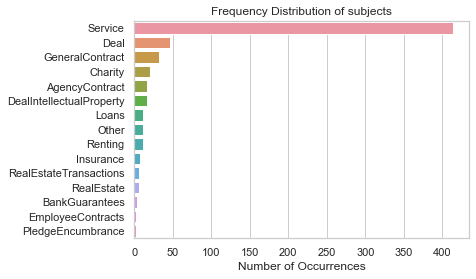


min 2
max 414
total 609


In [48]:
%matplotlib inline

subj_count = umtm.stats['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [49]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = umtm.stats['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(umtm.stats, 'subject')
class_weights

classes: ['Loans', 'GeneralContract', 'Service', 'BankGuarantees', 'Insurance', 'AgencyContract', 'RealEstateTransactions', 'Renting', 'Charity', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'RealEstate', 'Other', 'EmployeeContracts']


Service                     0.363840
Deal                        0.566576
GeneralContract             0.627292
Charity                     0.720418
AgencyContract              0.774149
DealIntellectualProperty    0.774149
Loans                       0.855116
Other                       0.855116
Renting                     0.855116
Insurance                   0.998227
RealEstateTransactions      1.127149
RealEstate                  1.127149
BankGuarantees              1.362792
EmployeeContracts           1.996455
PledgeEncumbrance           1.996455
Name: subject, dtype: float64

I0702 06:01:19.769685 4657720768 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 610
I0702 06:01:19.979475 4657720768 retrain_contract_uber_model.py:283] docs in meta: 610
I0702 06:01:19.987895 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 610


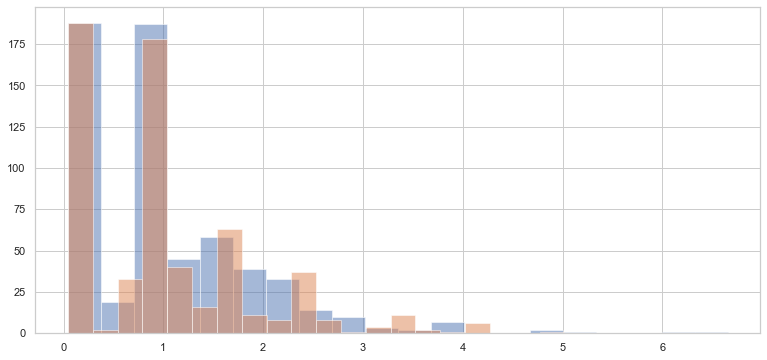

In [50]:
from trainsets.trainset_tools import get_feature_log_weights

def calculate_samples_weights(self):
  # TODO: sync with github!
  self.stats: DataFrame = self.load_contract_trainset_meta()
  self.stats['errors'] = umtm.stats['errors'].fillna(0)
  subject_weights = get_feature_log_weights(self.stats, 'subject')
  
  value_median = self.stats.value_log1p.median()

  for i, row in self.stats.iterrows():
    subj_name = row['subject']

    tagging_weight = 1.0
    if not pd.isna(row['user_correction_date']):  # MORE weight for user-corrected datapoints
      tagging_weight = 10.0  # TODO: must be estimated anyhow smartly

    value_weight = value_median
    if not pd.isna(row['value_log1p']):
      # вес пропорционален логорифму цены контракта,
      # чтобы было меньше ошибок в контрактах на большие суммы)
      value_weight = row['value_log1p']

    tagging_weight *= value_weight
    subject_weight = tagging_weight * class_weights[subj_name]

    if 'errors' in row:
      a = float( row['errors'] + 1.0)

#       ## giving more weight to incorrectly analyzed docs
#       subject_weight = subject_weight *(1.0 + row['errors'])
      tagging_weight *= a

    self.stats.at[i, 'subject_weight'] = subject_weight
    self.stats.at[i, 'sample_weight']  = tagging_weight

  # NORMALIZE weights, so the sum == Number of samples
  self.stats.sample_weight /= self.stats.sample_weight.mean()
  self.stats.subject_weight /= self.stats.subject_weight.mean()

  self._save_stats()

calculate_samples_weights(umtm)

plt.figure(figsize=(13, 6))

umtm.stats['subject_weight'].hist(bins=20, alpha=0.5)
umtm.stats['sample_weight'].hist(bins=20, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

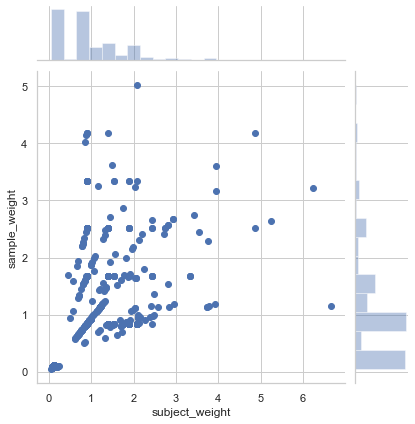

In [51]:
sns.jointplot(x="subject_weight", y="sample_weight", data=umtm.stats )
plt.show()


### look into trainset

In [52]:
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = umtm.stats.index[0]
print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
dp = umtm.make_xyw(SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
 

SAMPLE_DOC_ID 5eea279dc28b75807f3dacce


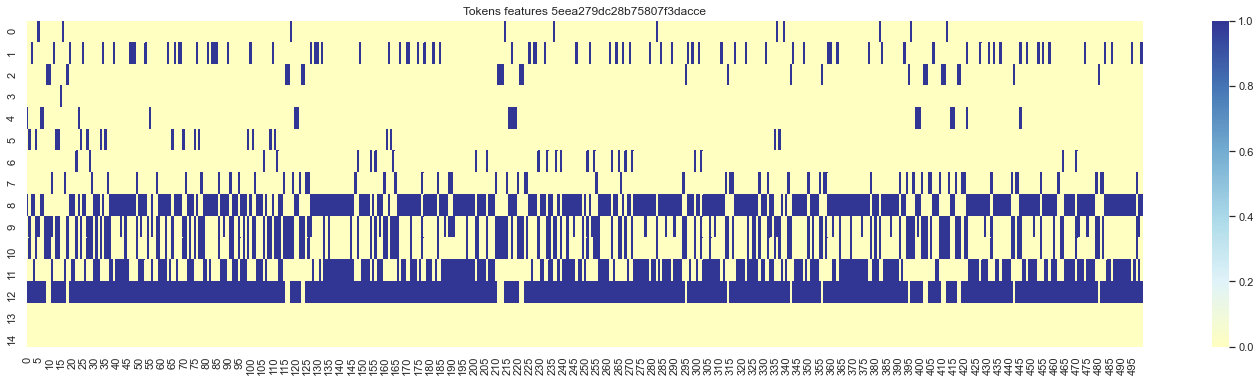

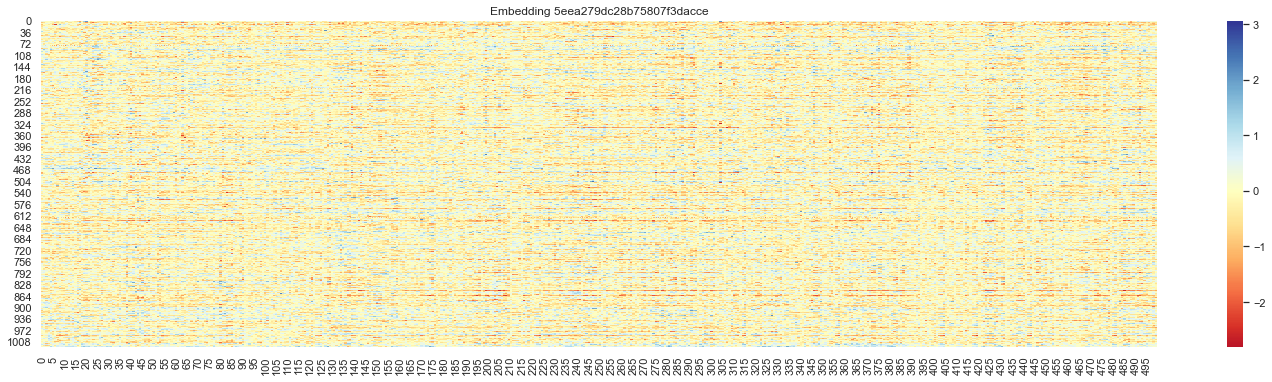

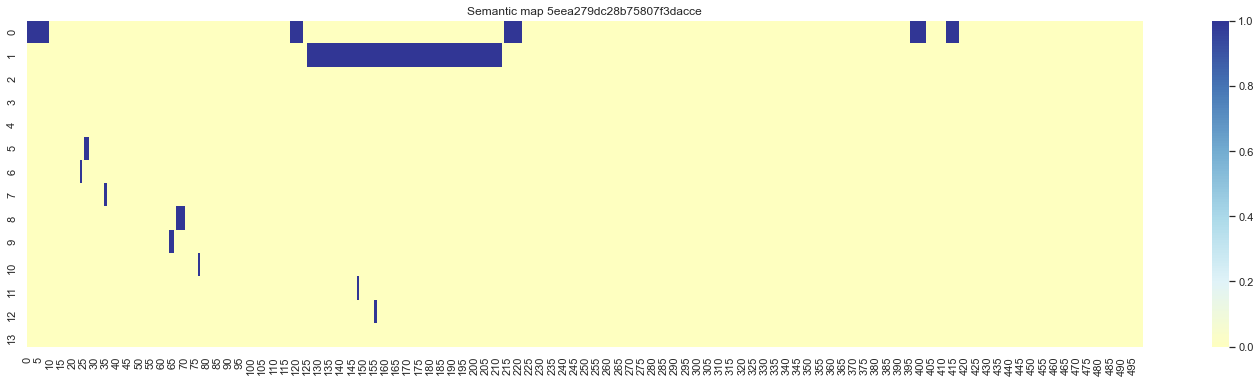

In [53]:
%matplotlib inline

plot_embedding(tok_f[:500], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:500], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:500], title=f'Semantic map {SAMPLE_DOC_ID}')

## Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

In [54]:
def make_generator(self, indices: [int], batch_size: int, augment_samples=False):

  np.random.seed(42)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len =  random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = self.make_xyw(doc_id)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

      subject_weight_K=1.0
      if augment_samples:
        start_from = 0
        
        row = self.stats.loc[doc_id]
        if random.randint(1, 2) == 1:  # 50% of samples
          segment_center = random.randint(0, len(emb)-1) ##select random token as a center
          if not pd.isna(row['value_span']) and random.random()<0.7:        
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1 #lower subject weight because there mighе be no information about subject around doc. value

      dp = self.trim_maxlen(dp, start_from, max_len)
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Return a tuple of (input, output, weights) to feed the network
    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
            [np.array(batch_output_sm), np.array(batch_output_subj)],
            [np.array(weights), np.array(weights_subj)])

train_indices[0]: 5edbadd7da3678279fbcaabf
test_indices[0]: 5ed2fce89305fa48fa28b352
X: 2 X[0]= (24, 952, 1024) X[1]= (24, 952, 15)
Y: 2 Y[0]= (24, 952, 14) Y[1]= (24, 43)


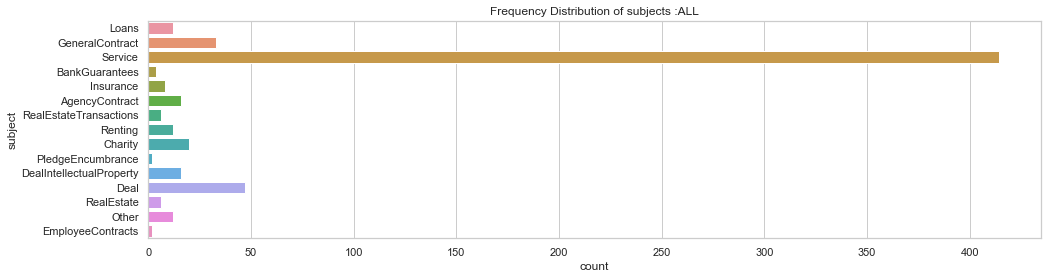

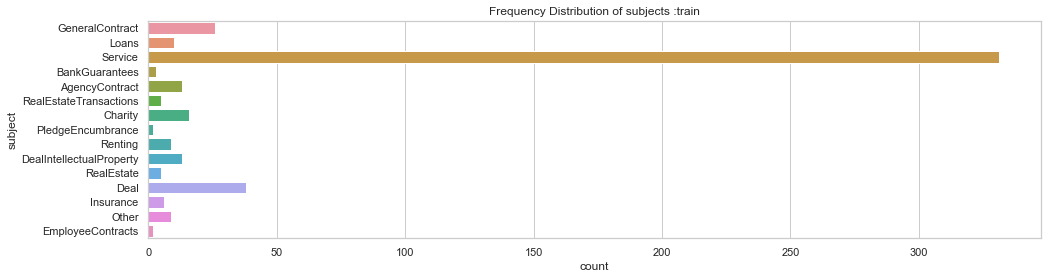

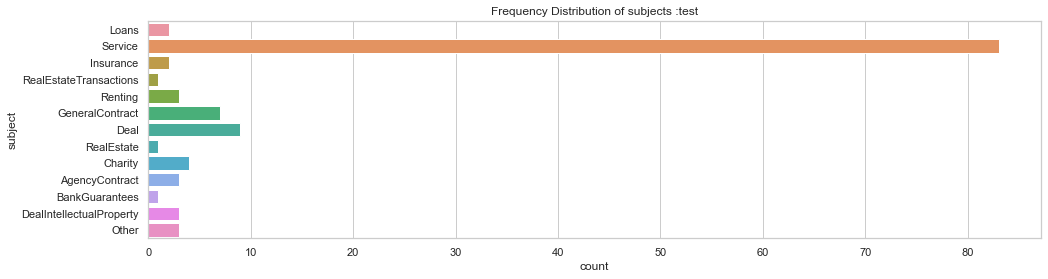

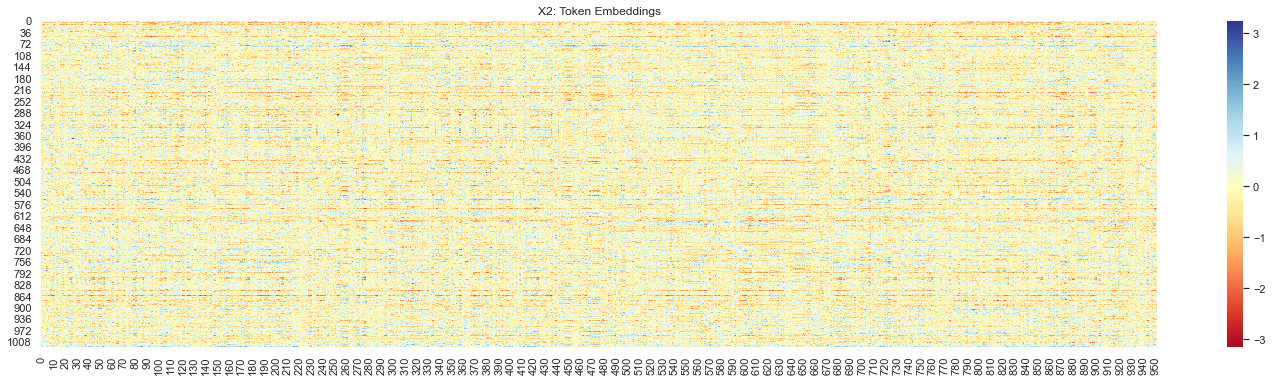

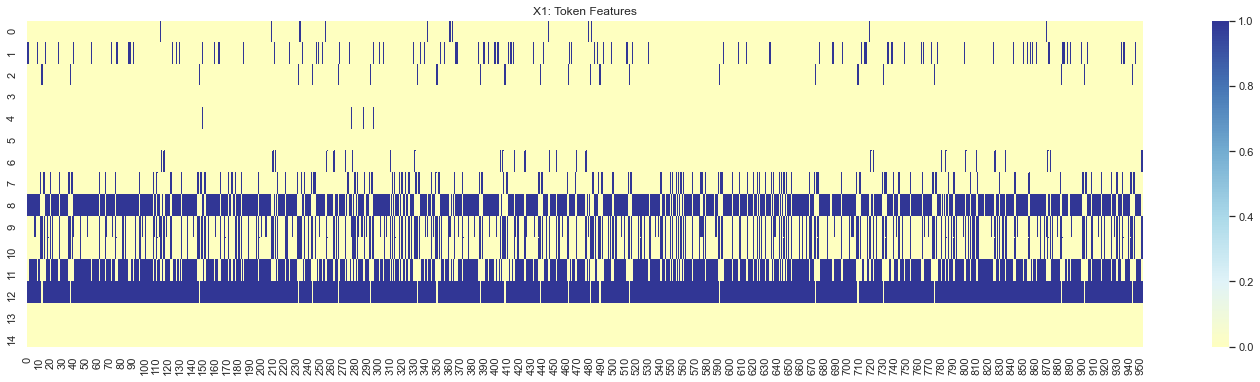

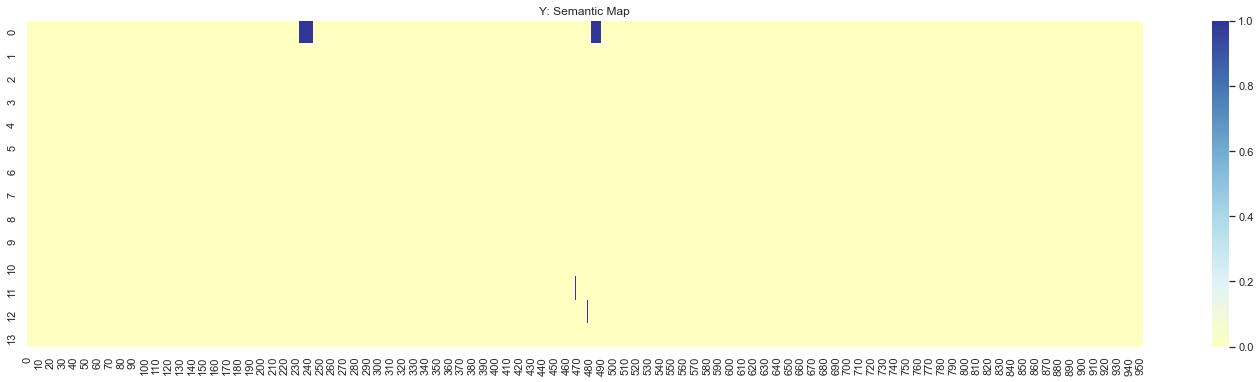

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [55]:
EPOCHS = 50
BATCH_SIZE = 24
EMB =  1024
 
_SELFTEST = True


_train, _test = train_test_split(umtm.stats, test_size=0.2, stratify=umtm.stats[['subject']])
train_indices = list(_train.index)
test_indices = list(_test.index)


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(umtm.stats, 'ALL')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(train_indices)], 'train')
plot_subject_distr(umtm.stats[umtm.stats.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
  print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
  print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

  plot_embedding(x[0][0], 'X2: Token Embeddings')
  plot_embedding(x[1][0], 'X1: Token Features')
  plot_embedding(y[0][0], 'Y: Semantic Map')
  
  print(y[0][1])

  del x
  del w
  del y
  del train_gen

In [56]:

ctx = KerasTrainingContext(umtm.work_dir, session_index=21)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


batch_size:	24
train_samples:	1952
test_samples:	122
steps_per_epoch:	81
validation_steps:	40


In [57]:



def init_model(model_fn) -> (Model, KerasTrainingContext):
  model_name = model_fn.__name__
  model = model_fn(name=model_name, ctx=ctx, trained=True)
  model.name = model_name

  weights_file_old = os.path.join(models_path, model_name + ".weights")
  weights_file_new = os.path.join(umtm.work_dir, model_name + ".weights")

  try:
    model.load_weights(weights_file_new, by_name=True )
    logger.info(f'weights loaded: {weights_file_new}')

  except:
    msg = f'cannot load  {model_name} from  {weights_file_new}'
    warnings.warn(msg)
    logger.warning(msg)
    model.load_weights(weights_file_old, by_name=True )
    logger.info(f'weights loaded: {weights_file_old}')

  # freeze bottom 6 layers, including 'embedding_reduced' #TODO: this must be model-specific parameter
  for l in model.layers[0:6]:
    l.trainable = False

  model.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  model.summary()

  return model




# Models 🦖

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [58]:
umodel = init_model(uber_detection_model_005_1_1)

INFO - 2020-07-02 06:01:56,525 - retrain_ipynb - weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
INFO - 2020-07-02 06:01:56,525 - retrain_ipynb - weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
I0702 06:01:56.525786 4657720768 <ipython-input-57-efc5081f7da4>:11] weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights


Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

In [59]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################

if TRAIN:
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

  ctx.EPOCHS = 25
  ctx.EVALUATE_ONLY = False
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

model.name == uber_detection_model_005_1_1
continue: lr:0.0020000000949949026, epoch:0
Epoch 1/25
81/81 [==============================] - 162s 2s/step - loss: 0.0317 - O1_tagging_loss: 0.0101 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0863 - O1_tagging_mse: 0.0024 - O1_tagging_binary_crossentropy: 0.0102 - O2_subject_kullback_leibler_divergence: 0.9860 - O2_subject_mse: 0.0097 - O2_subject_binary_crossentropy: 0.0356 - val_loss: 0.0290 - val_O1_tagging_loss: 0.0116 - val_O2_subject_loss: 0.0234 - val_O1_tagging_kullback_leibler_divergence: 0.0449 - val_O1_tagging_mse: 0.0024 - val_O1_tagging_binary_crossentropy: 0.0105 - val_O2_subject_kullback_leibler_divergence: 0.4128 - val_O2_subject_mse: 0.0041 - val_O2_subject_binary_crossentropy: 0.0164

Epoch 00001: val_loss improved from inf to 0.02896, saving model to /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
Epoch 2/25
81/81 [==============================] - 145s 2s/step - loss: 0.0338


Epoch 00011: val_loss did not improve from 0.02606
Epoch 12/25
81/81 [==============================] - 166s 2s/step - loss: 0.0296 - O1_tagging_loss: 0.0100 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0791 - O1_tagging_mse: 0.0023 - O1_tagging_binary_crossentropy: 0.0097 - O2_subject_kullback_leibler_divergence: 0.9342 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0341 - val_loss: 0.0411 - val_O1_tagging_loss: 0.0088 - val_O2_subject_loss: 0.0204 - val_O1_tagging_kullback_leibler_divergence: 0.0475 - val_O1_tagging_mse: 0.0016 - val_O1_tagging_binary_crossentropy: 0.0081 - val_O2_subject_kullback_leibler_divergence: 0.3511 - val_O2_subject_mse: 0.0035 - val_O2_subject_binary_crossentropy: 0.0141

Epoch 00012: val_loss did not improve from 0.02606
Epoch 13/25
81/81 [==============================] - 166s 2s/step - loss: 0.0302 - O1_tagging_loss: 0.0102 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0805 - O1_tagging_mse: 

81/81 [==============================] - 171s 2s/step - loss: 0.0261 - O1_tagging_loss: 0.0084 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0707 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0089 - O2_subject_kullback_leibler_divergence: 0.8499 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0311 - val_loss: 0.0172 - val_O1_tagging_loss: 0.0097 - val_O2_subject_loss: 0.0166 - val_O1_tagging_kullback_leibler_divergence: 0.0461 - val_O1_tagging_mse: 0.0017 - val_O1_tagging_binary_crossentropy: 0.0084 - val_O2_subject_kullback_leibler_divergence: 0.3199 - val_O2_subject_mse: 0.0031 - val_O2_subject_binary_crossentropy: 0.0130

Epoch 00022: val_loss did not improve from 0.01150
Epoch 23/25
81/81 [==============================] - 172s 2s/step - loss: 0.0250 - O1_tagging_loss: 0.0081 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0705 - O1_tagging_mse: 0.0021 - O1_tagging_binary_crossentropy: 0.0087 - O2_subject_kul

In [60]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Nadam', metrics=super_contract_model.metrics)
  umodel.summary()

  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

81/81 [==============================] - 184s 2s/step - loss: 0.0266 - O1_tagging_loss: 0.0096 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0660 - O1_tagging_mse: 0.0020 - O1_tagging_binary_crossentropy: 0.0086 - O2_subject_kullback_leibler_divergence: 0.8050 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0296 - val_loss: 0.0205 - val_O1_tagging_loss: 0.0081 - val_O2_subject_loss: 0.0154 - val_O1_tagging_kullback_leibler_divergence: 0.0417 - val_O1_tagging_mse: 0.0015 - val_O1_tagging_binary_crossentropy: 0.0078 - val_O2_subject_kullback_leibler_divergence: 0.3066 - val_O2_subject_mse: 0.0030 - val_O2_subject_binary_crossentropy: 0.0124

Epoch 00032: val_loss improved from 0.02098 to 0.02045, saving model to /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights
Epoch 33/50
81/81 [==============================] - 181s 2s/step - loss: 0.0238 - O1_tagging_loss: 0.0092 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence

KeyboardInterrupt: 

# Evaluate models

In [80]:
umodel = ctx.init_model(uber_detection_model_005_1_1, trained=True)

weights loaded: /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.weights


### training history

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


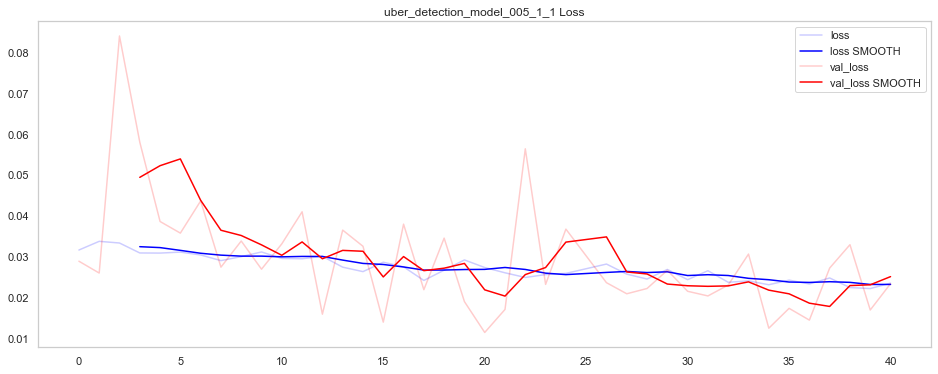

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


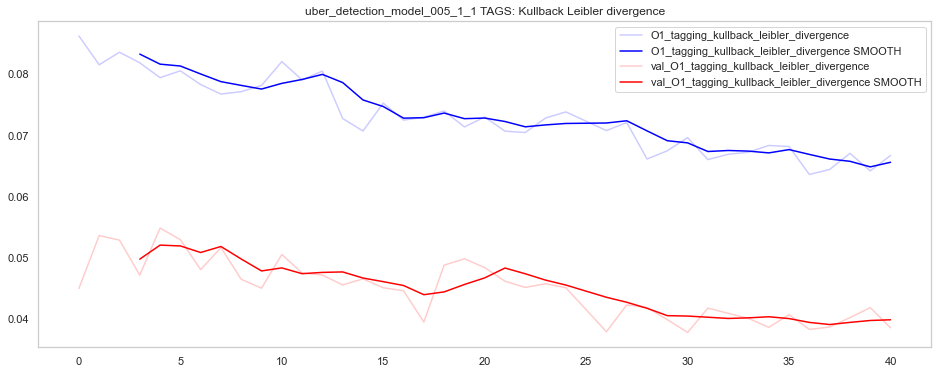

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


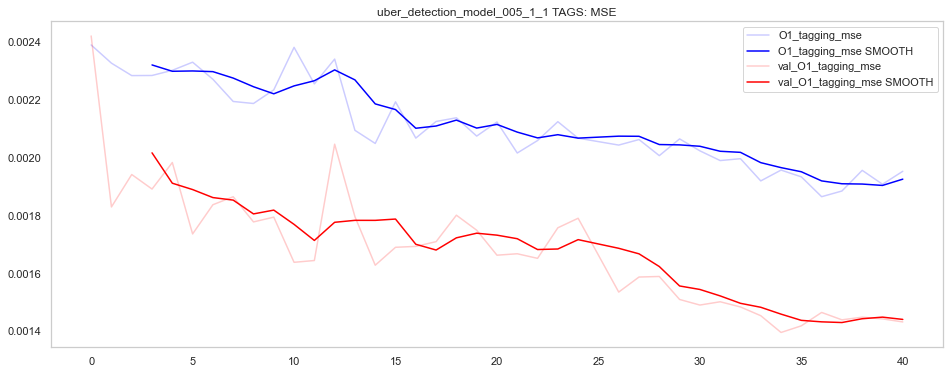

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


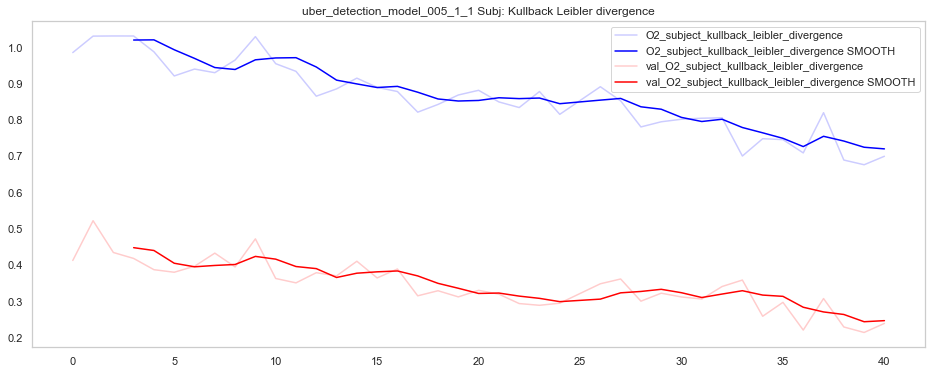

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


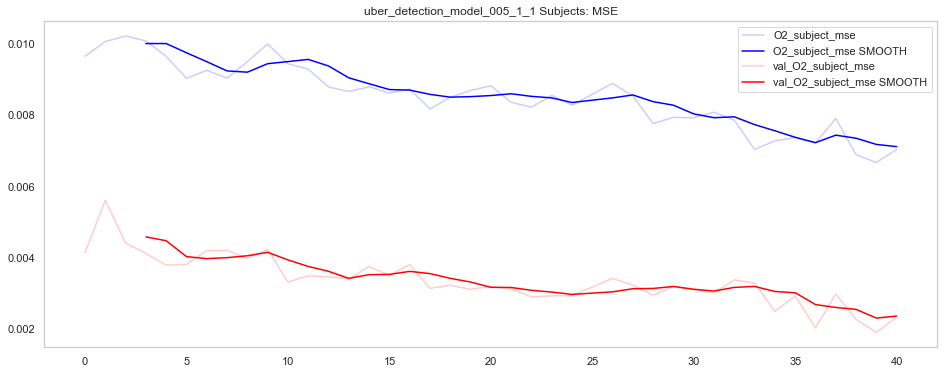

loading training log from /Users/artem/work/nemo/goil/work/uber_detection_model_005_1_1.21.log.csv


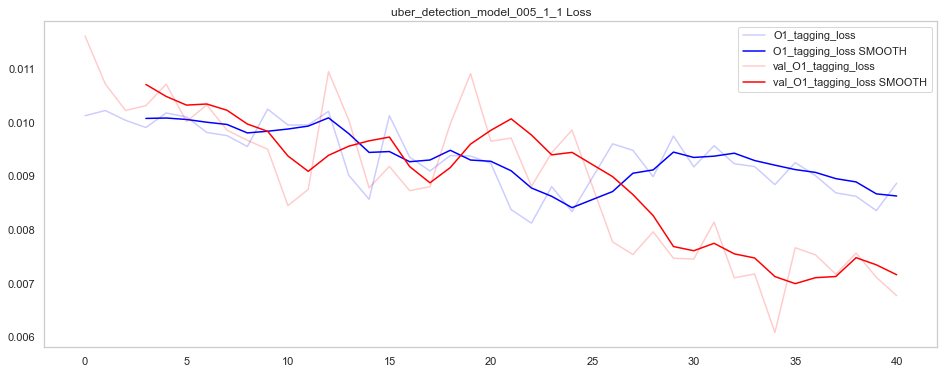

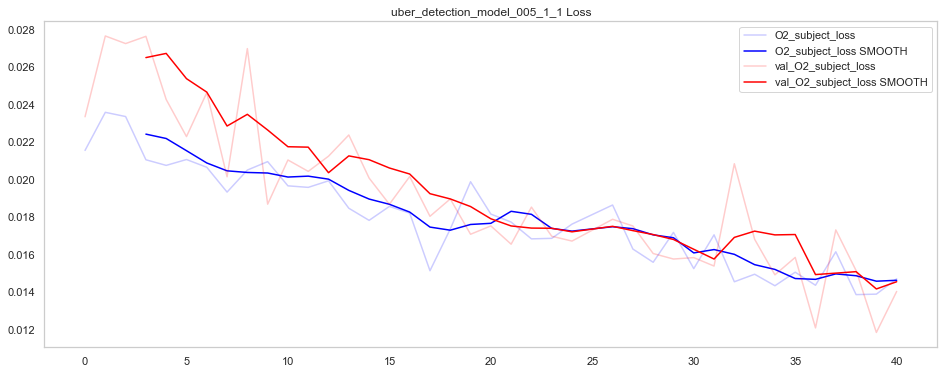

In [81]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.work_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid()
        plt.title(f'{metric}')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{m} {title}')
        plt.grid()
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        plt.savefig(img_path, bbox_inches='tight')
        plt.grid()
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')

## Contract subj Confusion matrices

In [82]:
from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)


def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
  att = tagging[tagname].values
  slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
  if len(slices) > 0:
    span = slices[0].start, slices[0].stop
    value = textmap.text_range(span)
    tag = SemanticTag(tagname, value, span)
    tag.confidence = att[slices[0]].mean()
    return tag
  return None


agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]
tagnames = solo_tags + agent_tags


def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = fetch_tag_value(key, _map, tagsmap)
    results[key] = t
    # print(t)

  ca = ContractAgent()
  ca.name =  results['org-1-name'] #TODO: check for NONE
  ca.type =  results['org-1-type']
  ca.alias = results['org-1-alias']
  normalize_contract_agent(ca)

  ca = ContractAgent()
  ca.name =  results['org-2-name'] #TODO: check for NONE
  ca.type =  results['org-2-type']
  ca.alias = results['org-2-alias']
  normalize_contract_agent(ca)

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]


def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    x, y, _ = umtm.make_xyw(_id)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
    try:
        r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
        put_results_into_df(_id, r, tags, jdoc)
    except:
        # TODO:
        logger.error(f'{_id}')
        pass

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags


subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
ev, tags = make_subj_predictions(umodel, subset.index)
tags.to_csv('all_contracts_predicstions.csv')

I0702 09:18:00.410027 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5deba9034ddc27bcf92dd383 0 of 422
/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
I0702 09:18:03.066862 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ded4e284ddc27bcf92dd6ce 1 of 422
I0702 09:18:03.249206 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ded4e294ddc27bcf92dd6d4 2 of 422
I0702 09:18:03.791479 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ded4e294ddc27bcf92dd6d5 3 of 422
I0702 09:18:04.060189 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5df620b9200a3f4d0fad777c 4 of 422
I0702 09:18:04.519961 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5dfa6a938d25a1ac83160bee 5 of 422
I0702 09:18:05.375864 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5dfa6a938d25a1ac83160bf1 6 of 422
I0702 09:18:07.987605 4657720768

I0702 09:18:46.813761 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ed2fce99305fa48fa28b359 70 of 422
I0702 09:18:47.146044 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ed2fcea9305fa48fa28b381 71 of 422
I0702 09:18:48.313724 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee190fb2281f29204c522f7 72 of 422
I0702 09:18:48.664385 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee190fb2281f29204c522f9 73 of 422
I0702 09:18:49.072026 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee190fb2281f29204c522f6 74 of 422
I0702 09:18:49.421576 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee190fb2281f29204c522fa 75 of 422
I0702 09:18:49.768735 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee190fb2281f29204c522f8 76 of 422
I0702 09:18:49.978337 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee8c456c28b75807f3dabe1 77 of 422
I0702 09:18:50.604634 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] va

I0702 09:19:30.927710 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbadd8da3678279fbcaadc 141 of 422
I0702 09:19:31.710898 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbadd8da3678279fbcaaf8 142 of 422
I0702 09:19:33.708111 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbadd8da3678279fbcaafb 143 of 422
I0702 09:19:34.228782 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbadd8da3678279fbcaafd 144 of 422
I0702 09:19:34.894276 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbadd9da3678279fbcaaff 145 of 422
I0702 09:19:35.495077 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc59cda3678279fbcac7d 146 of 422
I0702 09:19:35.735573 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc59cda3678279fbcac89 147 of 422
I0702 09:19:35.951514 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc59dda3678279fbcac8b 148 of 422
I0702 09:19:36.530498 4657720768 <ipython-input-82-c6a8c5c7d2a0>

I0702 09:20:16.672083 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc666da3678279fbcaf3d 212 of 422
I0702 09:20:17.607697 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc666da3678279fbcaf3f 213 of 422
I0702 09:20:18.212143 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc667da3678279fbcaf50 214 of 422
I0702 09:20:19.785886 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc667da3678279fbcaf51 215 of 422
I0702 09:20:20.319715 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc667da3678279fbcaf52 216 of 422
I0702 09:20:20.791410 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc667da3678279fbcaf53 217 of 422
I0702 09:20:21.314191 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc667da3678279fbcaf65 218 of 422
I0702 09:20:23.591226 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5edbc668da3678279fbcaf6e 219 of 422
I0702 09:20:24.162175 4657720768 <ipython-input-82-c6a8c5c7d2a0>

I0702 09:21:12.953466 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee372c52281f29204c525c8 283 of 422
I0702 09:21:13.785922 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee372c52281f29204c525c9 284 of 422
I0702 09:21:14.422458 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee372c62281f29204c525cb 285 of 422
I0702 09:21:15.274111 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee372c62281f29204c525cc 286 of 422
I0702 09:21:16.015507 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee372c62281f29204c525cd 287 of 422
I0702 09:21:16.904348 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee372c62281f29204c525e6 288 of 422
I0702 09:21:17.599596 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee372c62281f29204c525e7 289 of 422
I0702 09:21:19.152107 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5ee372c82281f29204c5261f 290 of 422
I0702 09:21:20.957549 4657720768 <ipython-input-82-c6a8c5c7d2a0>

I0702 09:23:38.396250 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5eea27a3c28b75807f3dad96 354 of 422
I0702 09:23:40.058986 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5eea27a3c28b75807f3dad9d 355 of 422
I0702 09:23:40.811080 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5eea27a3c28b75807f3dad9f 356 of 422
I0702 09:23:41.522088 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5eea27a3c28b75807f3dada2 357 of 422
I0702 09:23:43.620434 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5eea27a3c28b75807f3dada9 358 of 422
I0702 09:23:44.231237 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5eea27a3c28b75807f3dadab 359 of 422
I0702 09:23:45.105581 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5eea27a4c28b75807f3dadad 360 of 422
I0702 09:23:46.046597 4657720768 <ipython-input-82-c6a8c5c7d2a0>:138] validating 5eea27a4c28b75807f3dadb7 361 of 422
I0702 09:23:47.740313 4657720768 <ipython-input-82-c6a8c5c7d2a0>

In [98]:
errors_report = ev [ ev.wrong == True].sort_values('expected_subj')
print(len(errors_report), 'wrong subjects of', len(tags))
errors_report[ ['predicted_subj', 'subject', 'org-1-alias','org-2-alias'] ]

24 wrong subjects of 422


,predicted_subj,subject,org-1-alias,org-2-alias
_id,,,,
5edbc66ada3678279fbcafb5,GeneralContract,AgencyContract,Принципал,Агент
5e587dce99b345c81a70340d,Insurance,BankGuarantees,ПРИНЦИПАЛ,ГАРАНТ
5eea27b0c28b75807f3daeae,Loans,BankGuarantees,ГАРАНТ,ПРИНЦИПАЛ
5eea27b0c28b75807f3daead,Loans,BankGuarantees,ГАРАНТ,ПРИНЦИПАЛ
5ded07024ddc27bcf92dd4c0,Renting,Deal,Арендатор,Арендодатель
5edbadd0da3678279fbcaa4d,RealEstateTransactions,Deal,Продавец,Покупатель
5dece9bf4ddc27bcf92dd419,AgencyContract,DealIntellectualProperty,Сублицензиат,Лицензиат
5eea27a1c28b75807f3dad38,AgencyContract,DealIntellectualProperty,Лицензиат,Сублицензиат
5edbc659da3678279fbcae37,AgencyContract,DealIntellectualProperty,Конечный пользователь,Сублицензиат


/Users/artem/work/nemo/goil/nlp_tools/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


uber_detection_model_005_1_1
                          precision    recall  f1-score   support

          AgencyContract      0.619     0.929     0.743        14
          BankGuarantees      1.000     0.250     0.400         4
                 Charity      1.000     1.000     1.000        17
                    Deal      0.935     0.956     0.945        45
DealIntellectualProperty      1.000     0.667     0.800        15
       EmployeeContracts      0.000     0.000     0.000         2
         GeneralContract      0.882     0.909     0.896        33
               Insurance      0.889     1.000     0.941         8
                   Loans      0.786     1.000     0.880        11
                   Other      1.000     0.917     0.957        12
       PledgeEncumbrance      1.000     1.000     1.000         2
              RealEstate      0.800     0.667     0.727         6
  RealEstateTransactions      0.857     1.000     0.923         6
                 Renting      0.857     1.000 

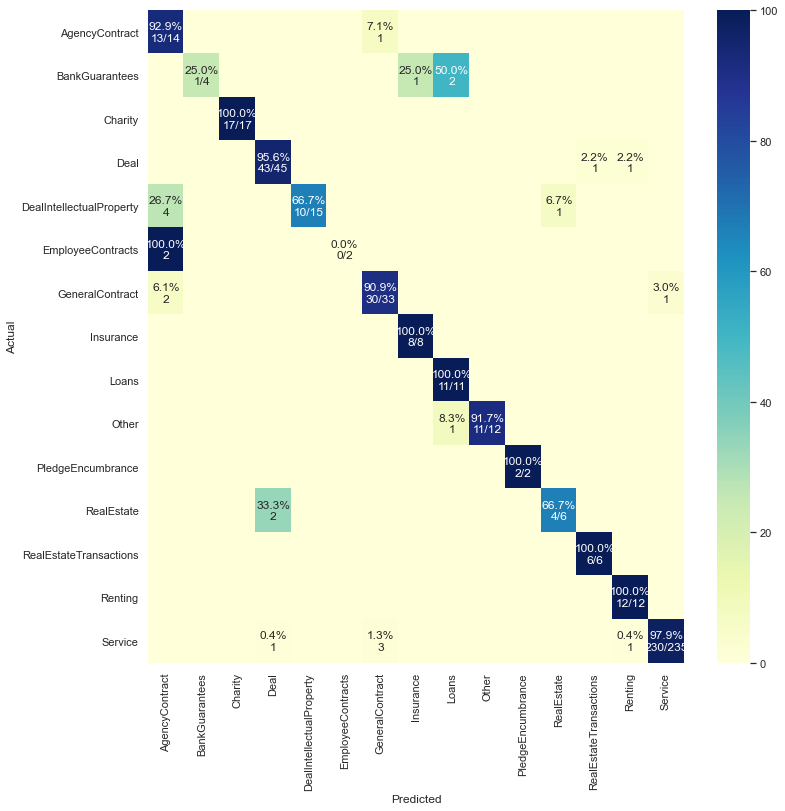

In [84]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


make_report(umodel, ev[~pd.isna(ev['predicted_subj'])])

# Evaluate tags detection

### Contract number validation

In [85]:
tags.fillna('-', inplace=True)
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
logger.info( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags)}%) were detected wronggly')
wrong_numbers[['p-number', 'number']].to_csv('wrong_numbers.csv')
wrong_numbers[['p-number', 'number']].tail(10)


INFO - 2020-07-02 09:25:04,533 - retrain_ipynb - Contract numbers: 86 of 422  (20.379146919431278%) were detected wronggly
INFO - 2020-07-02 09:25:04,533 - retrain_ipynb - Contract numbers: 86 of 422  (20.379146919431278%) were detected wronggly
I0702 09:25:04.533726 4657720768 <ipython-input-85-ecb3a56d0a44>:3] Contract numbers: 86 of 422  (20.379146919431278%) were detected wronggly


,p-number,number
5eea27b2c28b75807f3daee5,,РЗ-17-02.02/094/__________________
5edbadd7da3678279fbcaabf,САХ-16/09000/00070/Р.,САХ-16/09000/00070/Р
5edbc660da3678279fbcaeac,САХ-17/00000/00016/Р.,САХ-17/00000/00016/Р
5edbc668da3678279fbcaf6e,САХ-17/07000/00073/Р.,САХ-17/07000/00073/Р
5edbc65dda3678279fbcae56,САХ-17/09000/00010/Р.,САХ-17/09000/00010/Р
5edbc66bda3678279fbcafe6,-,САХ-17/09000/00019/Р
5edbc615da3678279fbcadc9,САХ-17/09000/00072/Р.,САХ-17/09000/00072/Р
5edbc616da3678279fbcadce,САХ-17/04000/00069/Р,№САХ-17/04000/00069/Р
5edbc665da3678279fbcaf1b,-,№САХ-17/10966/00053/Р
5edbc5afda3678279fbcad6e,ЭЮС-10701/17,№ЭЮС-10701/17


### Contract Org-1 validation

In [86]:
tags.fillna('-', inplace=True)
wrong_orgs1 = tags [ tags['org-1-name'] != tags['p-org-1-name']]
logger.info( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags)}%) were detected incorrectly')

wrong_numbers[['p-org-2-name', 'p-org-2-name', 'org-1-name', 'org-2-name']].to_csv('wrong_orgs1.csv')
wrong_orgs1[['p-org-2-name', 'p-org-2-name', 'org-1-name', 'org-2-name']].head(20)

INFO - 2020-07-02 09:25:04,609 - retrain_ipynb - Org-1 name: 35 of 422  (8.293838862559241%) were detected incorrectly
INFO - 2020-07-02 09:25:04,609 - retrain_ipynb - Org-1 name: 35 of 422  (8.293838862559241%) were detected incorrectly
I0702 09:25:04.609103 4657720768 <ipython-input-86-73e30de83334>:3] Org-1 name: 35 of 422  (8.293838862559241%) were detected incorrectly


,p-org-2-name,p-org-2-name,org-1-name,org-2-name
5ee188952281f29204c522de,Джессика Тавейра,Джессика Тавейра,Tenaris Global Services S. A.,Газпромнефть-Сахалин
5ee191e12281f29204c52303,гражданин Бишенов Руслан Ауесович,гражданин Бишенов Руслан Ауесович,Бишенов Руслан Ауесович,Газпромнефть-МНПЗ
5ee191e12281f29204c52304,-,-,Анцупов А. Н.,Газпромнефть-МНПЗ
5ee191e12281f29204c52306,Газпромнефть-МНПЗ,Газпромнефть-МНПЗ,Газпромнефть-МНПЗ,Газпромнефть-ОНПЗ
5ded07184ddc27bcf92dd510,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть-Сахалин,СОГАЗ
5de8a3fd1b3453848224a9d5,Спорт,Спорт,Газпромнефть-Транспорт,Спорт
5edbadd1da3678279fbcaa61,пожарного общества,пожарного общества,Адмиралтейское отделение Санкт-Петербургского ...,Газпромнефть-Сахалин
5edbadd2da3678279fbcaa77,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть Научно-Технический Центр,Газпромнефть-Сахалин
5edbadd3da3678279fbcaa8f,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть-Сахалин,СОГАЗ
5edbadd8da3678279fbcaaf8,Компания voestalpine Tubulars GmbH & Co KG,Компания voestalpine Tubulars GmbH & Co KG,voestalpine Tubulars GmbH & Co KG,Газпромнефть-Сахалин


In [87]:
tags.fillna('-', inplace=True)
wrong_orgs2 = tags [ tags['org-2-name'] != tags['p-org-2-name']]
logger.info( f'Org-2 name: {len(wrong_orgs2)} of {len(tags)}  ({100. * len(wrong_orgs2) / len(tags)}%) were detected incorrectly')
wrong_orgs2[['p-org-2-name', 'p-org-2-name', 'org-1-name', 'org-2-name']].head(10)


INFO - 2020-07-02 09:25:04,664 - retrain_ipynb - Org-2 name: 62 of 422  (14.691943127962086%) were detected incorrectly
INFO - 2020-07-02 09:25:04,664 - retrain_ipynb - Org-2 name: 62 of 422  (14.691943127962086%) were detected incorrectly
I0702 09:25:04.664765 4657720768 <ipython-input-87-d3310a2f18e4>:3] Org-2 name: 62 of 422  (14.691943127962086%) were detected incorrectly


,p-org-2-name,p-org-2-name,org-1-name,org-2-name
5ded4e284ddc27bcf92dd6ce,центр развития ребенка-детский сад № 135 города,центр развития ребенка-детский сад № 135 города,Газпромнефть-МНПЗ,центр развития ребенка - детский сад № 135 гор...
5ee188952281f29204c522de,Джессика Тавейра,Джессика Тавейра,Tenaris Global Services S. A.,Газпромнефть-Сахалин
5ee191e12281f29204c52303,гражданин Бишенов Руслан Ауесович,гражданин Бишенов Руслан Ауесович,Бишенов Руслан Ауесович,Газпромнефть-МНПЗ
5ee191e12281f29204c52304,-,-,Анцупов А. Н.,Газпромнефть-МНПЗ
5ee191e12281f29204c52306,Газпромнефть-МНПЗ,Газпромнефть-МНПЗ,Газпромнефть-МНПЗ,Газпромнефть-ОНПЗ
5ded004b4ddc27bcf92dd461,"Страховое общество газовой промышленности""","Страховое общество газовой промышленности""",Газпромнефть-Сахалин,Страховое общество газовой промышленности
5ded07184ddc27bcf92dd510,Газпромнефть-Сахалин,Газпромнефть-Сахалин,Газпромнефть-Сахалин,СОГАЗ
5ded07194ddc27bcf92dd5ed,Институт промышленной,Институт промышленной,Газпромнефть-Сахалин,ИПБОТСП
5dee80604ddc27bcf92dd88e,гражданин Трухан Александр,гражданин Трухан Александр,Газпромнефть-СМ,Трухан Александр Михайлович
5ee832322281f29204c52c29,"Норрексим Рус"" (АО ""Норрексим","Норрексим Рус"" (АО ""Норрексим",Газпромнефть-Каталитические системы,Норрексим Рус


In [88]:

wrong_aliases1 = tags [ tags['org-1-alias'] != tags['p-org-1-alias']]
logger.info( f'Alias-1: {len(wrong_aliases1)} of {len(tags)}  ({100. * len(wrong_aliases1) / len(tags)}%) were detected incorrectly')
# wrong_orgs[['p-org-1-alias', 'p-org-2-alias', 'org-1-alias', 'org-2-alias']].head(10)

wrong_aliases2 = tags [ tags['org-2-alias'] != tags['p-org-2-alias']]
logger.info( f'Alias-2: {len(wrong_aliases2)} of {len(tags)}  ({100. * len(wrong_aliases2) / len(tags)}%) were detected incorrectly')
wrong_aliases2[['p-org-1-alias', 'p-org-2-alias', 'org-1-alias', 'org-2-alias']].head(10)

INFO - 2020-07-02 09:25:04,728 - retrain_ipynb - Alias-1: 30 of 422  (7.109004739336493%) were detected incorrectly
INFO - 2020-07-02 09:25:04,728 - retrain_ipynb - Alias-1: 30 of 422  (7.109004739336493%) were detected incorrectly
I0702 09:25:04.728838 4657720768 <ipython-input-88-9e27cec1ce8a>:2] Alias-1: 30 of 422  (7.109004739336493%) were detected incorrectly
INFO - 2020-07-02 09:25:04,743 - retrain_ipynb - Alias-2: 41 of 422  (9.71563981042654%) were detected incorrectly
INFO - 2020-07-02 09:25:04,743 - retrain_ipynb - Alias-2: 41 of 422  (9.71563981042654%) were detected incorrectly
I0702 09:25:04.743904 4657720768 <ipython-input-88-9e27cec1ce8a>:6] Alias-2: 41 of 422  (9.71563981042654%) were detected incorrectly


,p-org-1-alias,p-org-2-alias,org-1-alias,org-2-alias
5e58df7823869ee435388239,-,Залогодатель,Залогодатель,Залогодержатель
5df7a66b200a3f4d0fad7874,-,-,ОБЩЕСТВО,ХРАНТРАНСНЕФТЬ
5e5de70d01c6c73c19eebd4a,Застройщик,подрядчик,Генеральный подрядчик,Застройщик
5ded06fa4ddc27bcf92dd4b9,-,-,Абонент,Оператор
5ded07184ddc27bcf92dd50e,Заказчик,Исполнитель,Заказчик,-
5dee80604ddc27bcf92dd88e,Общество,директор,Генеральный директор,Общество
5ee8c456c28b75807f3dabe3,Заказчик,Подрядчик,Заказчик,-
5ee832322281f29204c52c2c,Покупатель,-,Покупатель,Поставщик
5dece9bf4ddc27bcf92dd41b,-,-,Лицензиар,Лицензиат
5edbadc1da3678279fbcaa21,-,-,Заказчик,Исполнитель


In [89]:
wrong_types1 = tags [ tags['org-1-type'] != tags['p-org-1-type']]
wrong_types2 = tags [ tags['org-2-type'] != tags['p-org-2-type']]

In [90]:
from collections import Counter

counter = Counter()
for i in wrong_orgs1.index:
  counter[i]+=1
for i in wrong_orgs2.index:
  counter[i]+=1
for i in wrong_types1.index:
  counter[i]+=1
for i in wrong_types2.index:
  counter[i]+=1
for i in wrong_numbers.index:
  counter[i]+=1
for i in wrong_aliases1.index:
  counter[i]+=1
for i in wrong_aliases2.index:
  counter[i]+=1

for i in errors_report.index:#wrong subjects
  counter[i]+=1

print(counter.most_common()[0][0])
print(len(counter))

5edbc616da3678279fbcadce
212


In [91]:
umtm.stats['errors']=0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

I0702 09:25:05.163264 4657720768 retrain_contract_uber_model.py:256] TOTAL DATAPOINTS IN TRAINSET: 610
I0702 09:25:05.351434 4657720768 retrain_contract_uber_model.py:283] docs in meta: 610
I0702 09:25:05.359966 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 610
I0702 09:25:05.383358 4657720768 retrain_contract_uber_model.py:283] docs in meta: 610
I0702 09:25:05.389090 4657720768 retrain_contract_uber_model.py:286] docs in meta after drop_duplicates: 610


,export_date,subject,org-1-alias,org-2-alias,checksum,version,analyze_date,value,value_log1p,value_span,subject confidence,user_correction_date,valid,subject_weight,sample_weight,error,errors
_id,,,,,,,,,,,,,,,,,
5eea279dc28b75807f3dacce,2020-06-30 22:50:39.017762,Loans,Заемщик,Займодавец,a2fd74d33e546dc0fde7ae1d50eb3cae,1.22.1,2020-06-30 21:27:54.865,6.040500e+10,24.824338,148.0,0.997801,2020-06-17 15:44:57.491,True,3.949816,3.165251,NaN,1.0
5eea27adc28b75807f3dae66,2020-06-30 22:51:23.487143,GeneralContract,Заказчик/ЗАКАЗЧИК,Подрядчик/ПОДРЯДЧИК/ЕРС-Подрядчик,8a9ce8cea53e54a03caa5c252ad2bb7b,1.22.1,2020-06-30 22:19:35.189,2.807709e+10,24.058220,21847.0,0.955438,2020-06-19 05:39:50.512,True,2.808064,1.533783,NaN,0.0
5eea279dc28b75807f3daccb,2020-06-30 22:50:38.846598,Loans,Займодавец,Заемщик,839bd7f3a1a443ffdf00c200788df8b3,1.22.1,2020-06-30 21:27:51.400,2.215000e+09,21.518518,159.0,0.973850,2020-06-17 15:45:57.928,True,3.423825,2.743740,NaN,1.0
5eea27b1c28b75807f3daec7,2020-06-30 22:51:30.784849,GeneralContract,Заказчик,Подрядчик,571145b01a3a2e2ac7f486d3f73a1b19,1.22.1,2020-06-30 22:27:48.787,1.789183e+09,21.305025,4826.0,0.388674,2020-06-19 10:23:11.225,True,2.486712,1.358259,NaN,0.0
5dfa6a938d25a1ac83160bf1,2020-06-26 21:17:55.126244,Service,Заказчик,Исполнитель,e10d3bc6db3c286eddbbbc9107850830,1.11.2,2020-06-12 21:20:30.568,1.770000e+09,21.294245,9482.0,0.984551,2020-06-06 11:44:17.759,True,1.441607,2.715144,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5edbc65dda3678279fbcae68,2020-06-30 22:49:44.482732,Service,Заказчик,,e6050d7bfaa96e7a8b283c36c4490687,1.22.1,2020-06-30 20:08:00.030,NaN,NaN,NaN,0.994054,NaT,True,0.088824,0.083646,NaN,0.0
5edbc5a9da3678279fbcad29,2020-06-30 22:49:32.668289,Service,,,4e9bbffec18a5ce4417ea091ed871979,1.22.1,2020-06-30 19:49:34.496,NaN,NaN,NaN,0.998208,NaT,True,0.088824,0.083646,NaN,0.0
5edbadd7da3678279fbcaabd,2020-06-30 22:49:25.715525,Service,Заказчик,Исполнитель,f41c6fe54622dc70f276d07d7a1f86a1,1.22.1,2020-06-30 19:40:11.446,NaN,NaN,NaN,0.991027,NaT,True,0.088824,0.083646,NaN,0.0


## Single doc eval

In [92]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

I0702 09:25:05.530188 4657720768 <ipython-input-92-1b76c9271c48>:14] fetching 5edbc616da3678279fbcadce


SAMPLE_DOC_ID: 5edbc616da3678279fbcadce


/Users/artem/work/nemo/goil/nlp_tools/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


In [93]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

2 uber_detection_model_005_1_1
Subject: (<ContractSubject.Renting: 9>, 0.9886360168457031, 9)


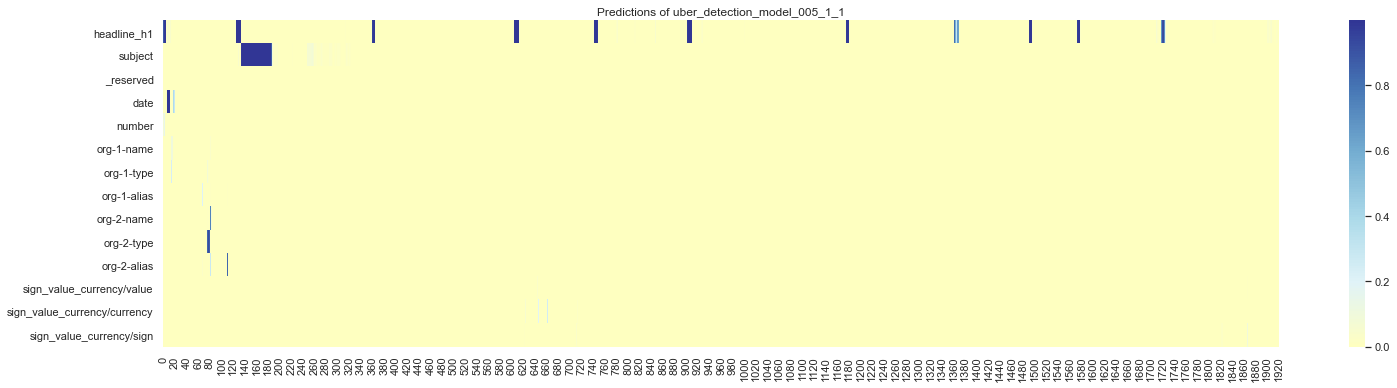

In [94]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [95]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  print(t.upper(), spans)
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


HEADLINE_H1 [slice(604, 614, None), slice(126, 134, None), slice(903, 911, None), slice(361, 366, None), slice(1574, 1579, None), slice(1491, 1497, None), slice(742, 749, None), slice(1176, 1181, None), slice(0, 5, None), slice(1719, 1725, None), slice(1362, 1370, None)]


SUBJECT [slice(134, 188, None)]


_RESERVED []


DATE [slice(7, 12, None), slice(18, 20, None)]


NUMBER [slice(2, 3, None)]


ORG-1-NAME []


ORG-1-TYPE [slice(14, 15, None)]


ORG-1-ALIAS []


ORG-2-NAME [slice(82, 83, None)]


ORG-2-TYPE [slice(77, 81, None)]


ORG-2-ALIAS [slice(111, 112, None)]


SIGN_VALUE_CURRENCY/VALUE []


SIGN_VALUE_CURRENCY/CURRENCY []


SIGN_VALUE_CURRENCY/SIGN []


In [99]:
mean_ = tagging.values.max(-1)*0.5
print (mean_.shape)
display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:14000],  mean_[:14000])))

(1921,)


In [107]:
from pandas import DataFrame

from analyser.contract_parser import ContractDocument, max_confident, max_value
from analyser.hyperparams import HyperParameters
from analyser.legal_docs import ContractValue, LegalDocument, extract_sum_sign_currency

# from analyser.parsing import find_value_sign_currency_attention
from analyser.ml_tools import FixedVector, estimate_confidence_by_mean_top_non_zeros
from analyser.transaction_values import complete_re as transaction_values_re

def find_value_sign_currency_attention(value_section_subdoc: LegalDocument,
                                       attention_vector_tuned: FixedVector or None,
                                       parent_tag=None,
                                       absolute_spans=False) ->  [ContractValue]:


  spans = [m for m in value_section_subdoc.tokens_map.finditer(transaction_values_re)]
  values_list = []

  for span in spans:
    value_sign_currency:ContractValue = extract_sum_sign_currency(value_section_subdoc, span)
    if value_sign_currency is not None:

      # Estimating confidence by looking at attention vector
      if attention_vector_tuned is not None:

        for t in value_sign_currency.as_list():
          t.confidence *= (HyperParameters.confidence_epsilon + estimate_confidence_by_mean_top_non_zeros(
            attention_vector_tuned[t.slice]))
      # ---end if

      value_sign_currency.parent.set_parent_tag(parent_tag)
      value_sign_currency.parent.span = value_sign_currency.span()  ##fix span
      values_list.append(value_sign_currency)

  # offsetting
  if absolute_spans:  # TODO: do not offset here!!!!
    for value in values_list:
      value += value_section_subdoc.start

  return values_list


def nn_find_contract_value(contract:ContractDocument, semantic_map: DataFrame) -> [ContractValue]:
  _keys = ['sign_value_currency/value', 'sign_value_currency/currency', 'sign_value_currency/sign']
  attention_vector = semantic_map[_keys].values.sum(axis=-1)

#   attention_vector = contract.distances_per_pattern_dict[attention_vector]
  values_list:  [ContractValue] = find_value_sign_currency_attention(contract, attention_vector )

 # ------
  # reduce number of found values
  # take only max value and most confident ones (we hope, it is the same finding)

  max_confident_cv: ContractValue = max_confident(values_list)
  max_valued_cv: ContractValue = max_value(values_list)
  if max_confident_cv == max_valued_cv:
    return [max_confident_cv]
  else:
    # TODO: Insurance docs have big value, its not what we're looking for. Biggest is not the best see https://github.com/nemoware/analyser/issues/55
    max_valued_cv *= 0.5
    return [max_valued_cv]

v = nn_find_contract_value(jdoc.asLegalDoc(), tagging)[0]
v

In [109]:
v.value.__dict__

{'kind': 'value',
 'value': 49500.0,
 '_parent_tag': <analyser.ml_tools.SemanticTag at 0x14617c4e0>,
 'span': (623, 624),
 'span_map': 'words',
 'confidence': 0.15945055878162384}